In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
from configs.RecursiveVPSDE.Markovian_8DLorenz.recursive_Markovian_PostMeanScore_8DLorenz_Stable_T256_H05_tl_110data_StbleTgt import get_config

In [2]:
num_paths = 10240
root_dir = "/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"
config = get_config()

In [3]:
def get_drift_files(config, root_dir):
    ts_type = f"{config.ndims}DLnz"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/8DLnz/"
    true_files = []
    local_files = []
    for file in os.listdir(root_nadaraya_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file and ((f"{config.forcing_const}FConst").replace(".","") in file):
            if "true" in file:
                true_files.append(root_nadaraya_dir+file)
            elif "global" in file:
                local_files.append(root_nadaraya_dir+file)
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[3][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws

In [4]:
config = get_config()
true_files, local_files, bws = get_drift_files(config=config, root_dir=root_dir)
local_files

['/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/Nadaraya/8DLnz/IIDNadaraya_f8DLnz_DriftTrack_0018211bw_10240NPaths_00t0_3906e-03dT_075FConst_global_states.npy',
 '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/Nadaraya/8DLnz/IIDNadaraya_f8DLnz_DriftTrack_0024046bw_10240NPaths_00t0_3906e-03dT_075FConst_global_states.npy',
 '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/Nadaraya/8DLnz/IIDNadaraya_f8DLnz_DriftTrack_0031749bw_10240NPaths_00t0_3906e-03dT_075FConst_global_states.npy',
 '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/Nadaraya/8DLnz/IIDNadaraya_f8DLnz_DriftTrack_0041919bw_10240NPaths_00t0_3906e-03dT_075FConst_global_states.npy',
 '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Stat

/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_40154/3568929358.py:13: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_40154/3568929358.py:14: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


12.56768786218503 0.0018211 inf


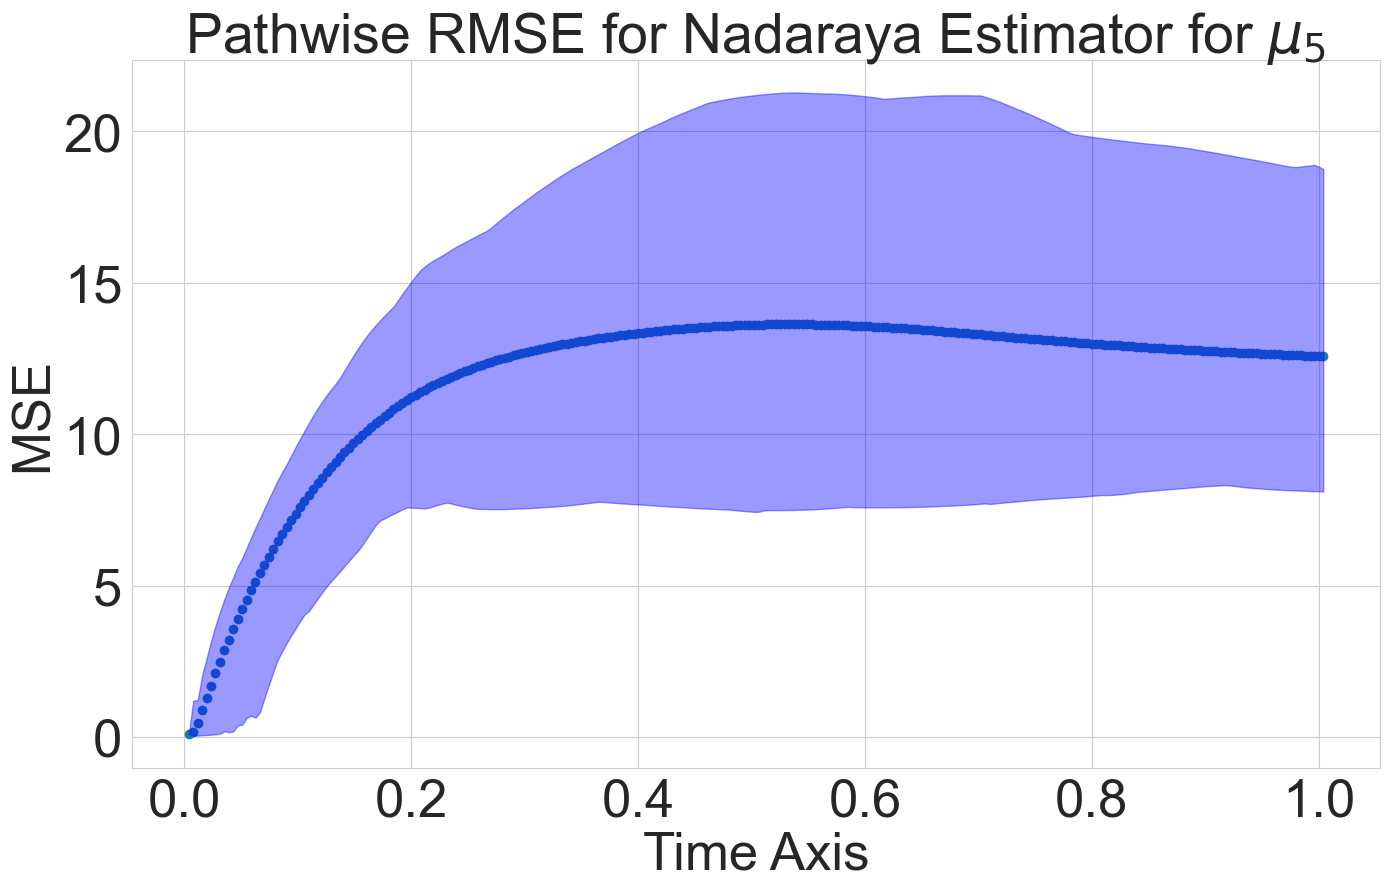

Final time cumulative MSE local-time error 12.56768786218503 at bw 0.0018211 for 0.75FConst

12.364314754235718 0.0024046 12.56768786218503


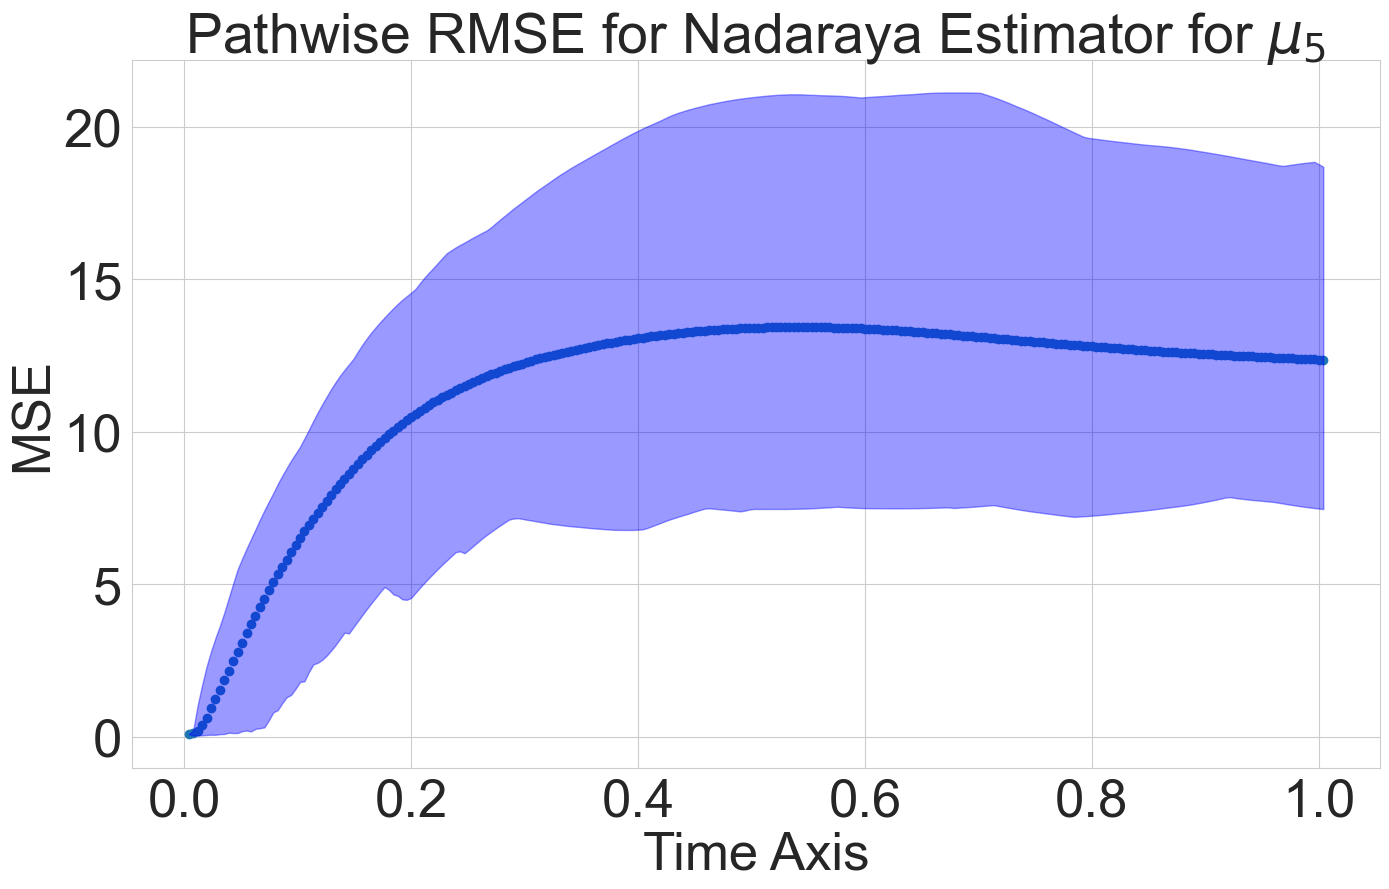

Final time cumulative MSE local-time error 12.364314754235718 at bw 0.0024046 for 0.75FConst

11.985449453040081 0.0031749 12.364314754235718


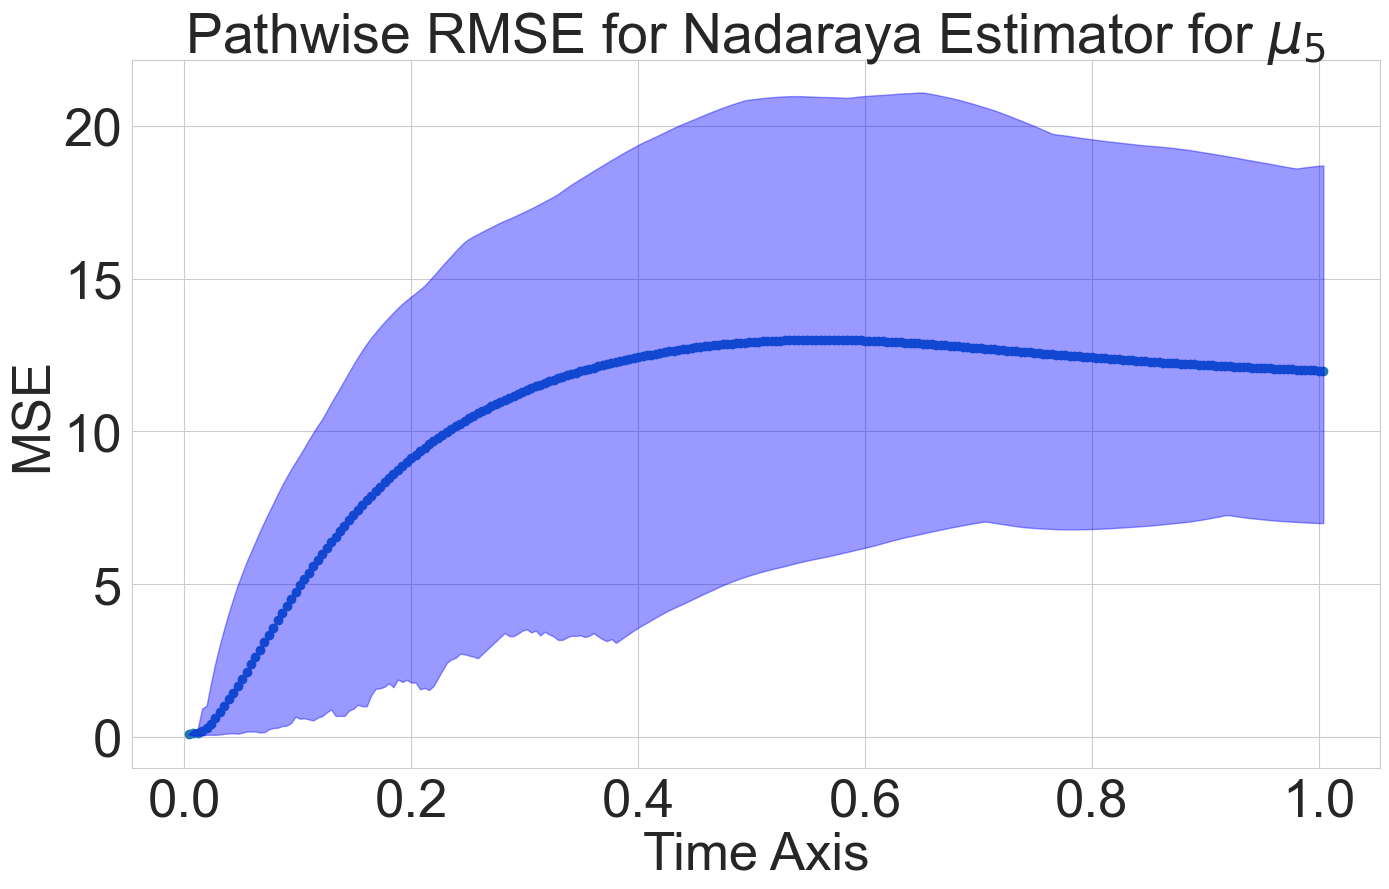

Final time cumulative MSE local-time error 11.985449453040081 at bw 0.0031749 for 0.75FConst

11.302787436034018 0.0041919 11.985449453040081


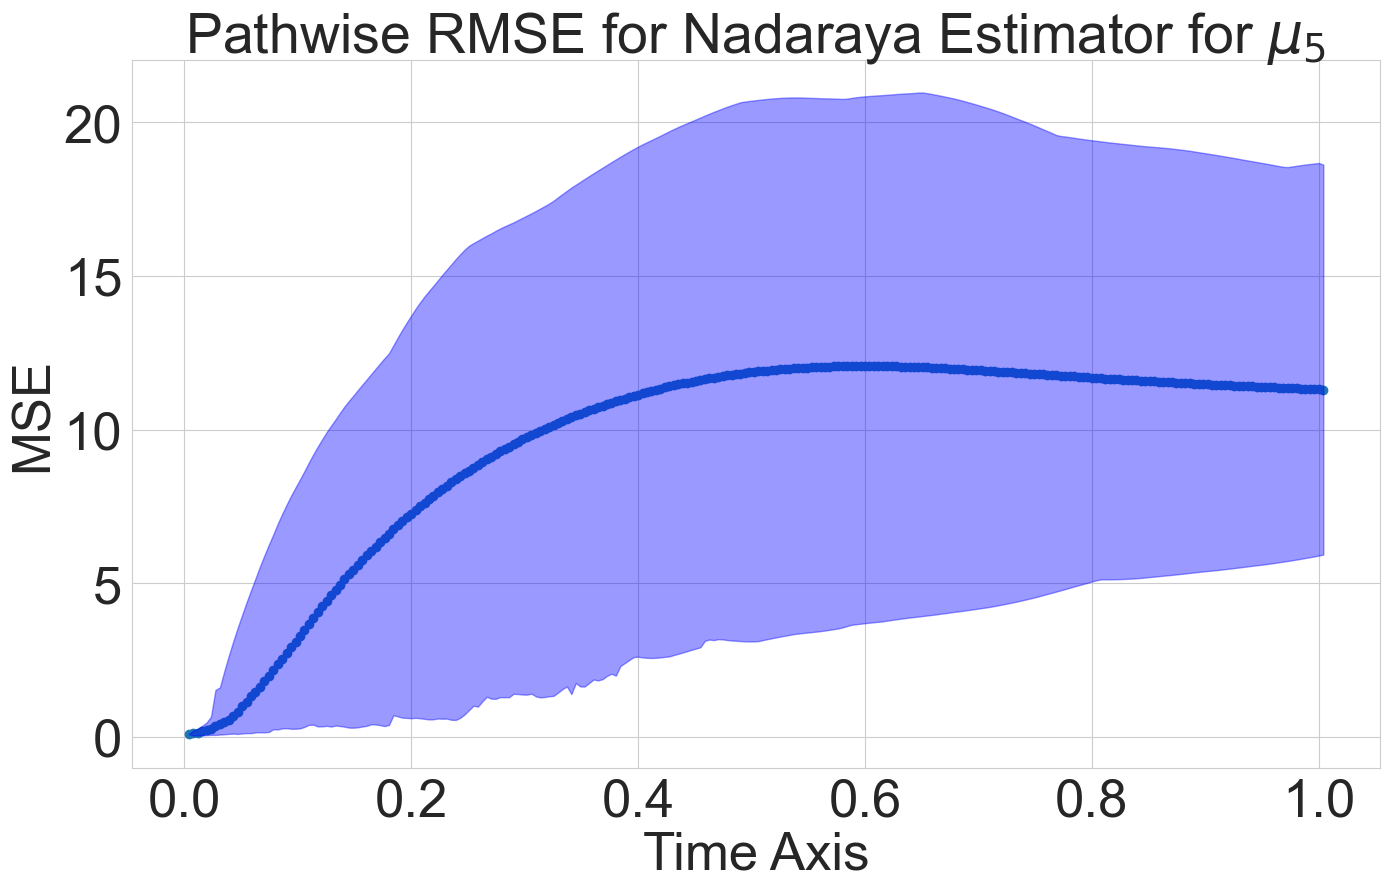

Final time cumulative MSE local-time error 11.302787436034018 at bw 0.0041919 for 0.75FConst

10.217524347609855 0.0055348 11.302787436034018


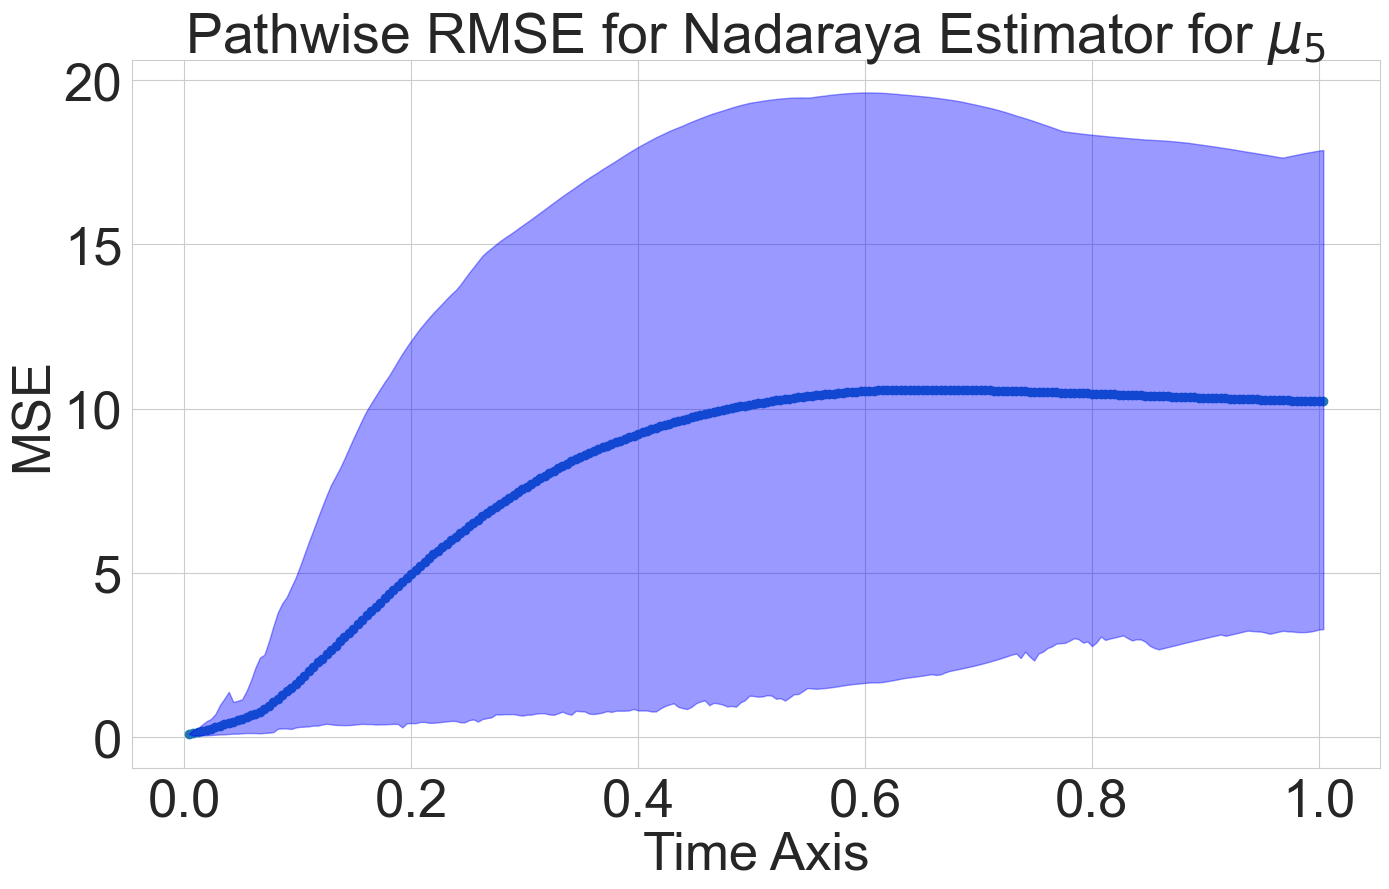

Final time cumulative MSE local-time error 10.217524347609855 at bw 0.0055348 for 0.75FConst

8.734515544679773 0.0073079 10.217524347609855


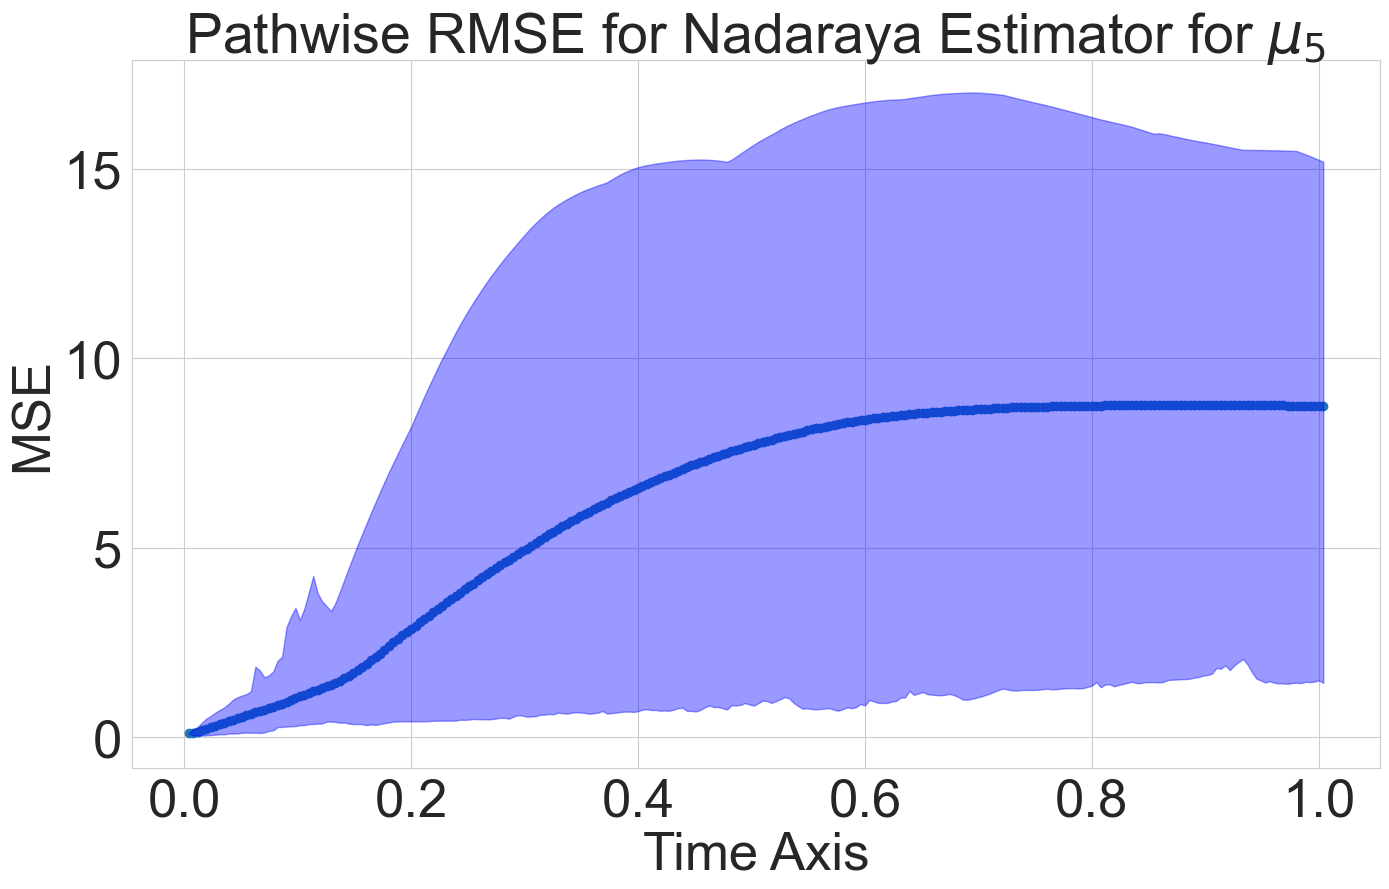

Final time cumulative MSE local-time error 8.734515544679773 at bw 0.0073079 for 0.75FConst

6.9487201784892205 0.009649 8.734515544679773


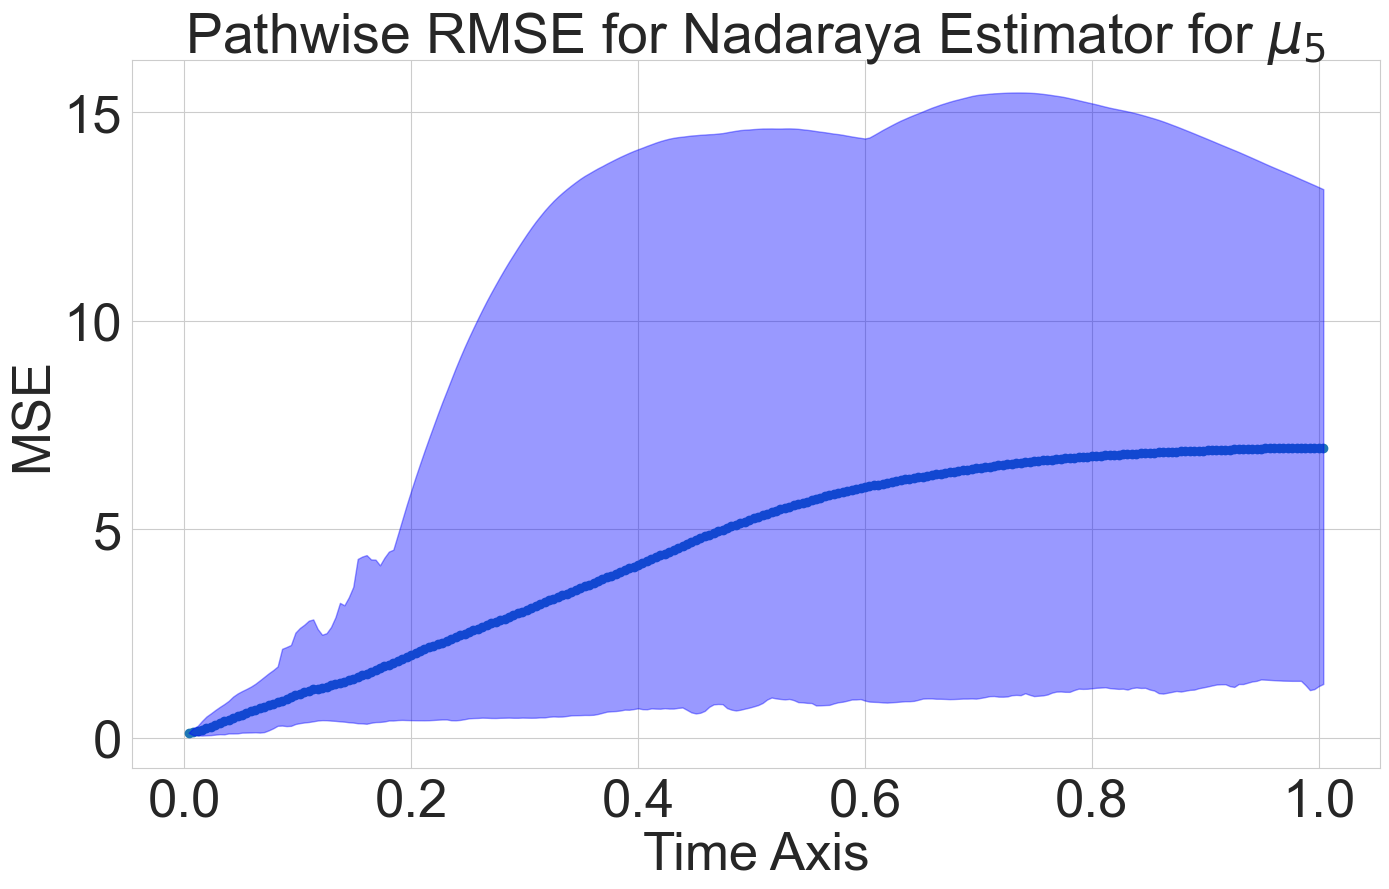

Final time cumulative MSE local-time error 6.9487201784892205 at bw 0.009649 for 0.75FConst

5.655117001240355 0.0127401 6.9487201784892205


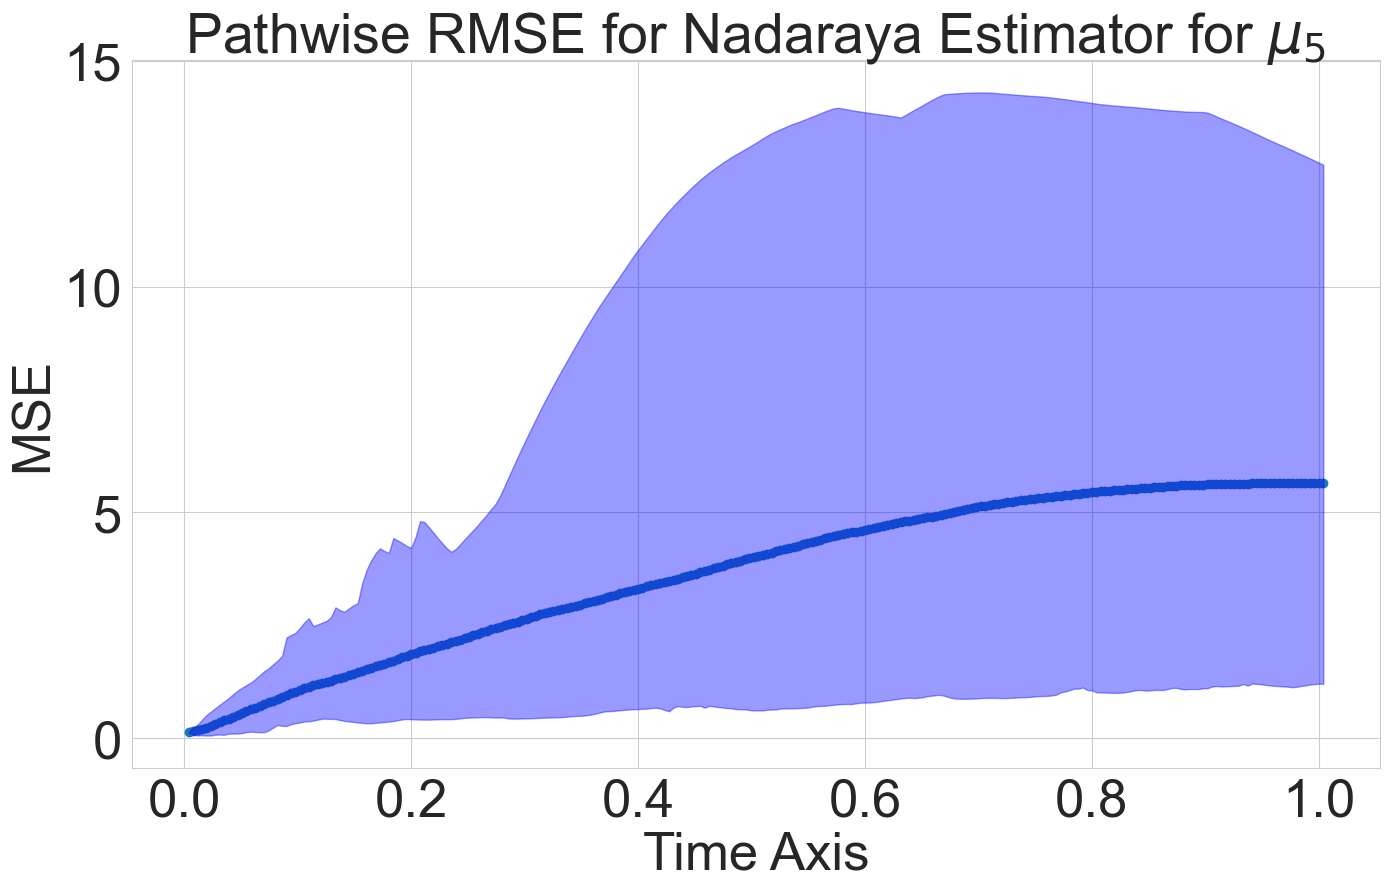

Final time cumulative MSE local-time error 5.655117001240355 at bw 0.0127401 for 0.75FConst

4.766290334167042 0.0168214 5.655117001240355


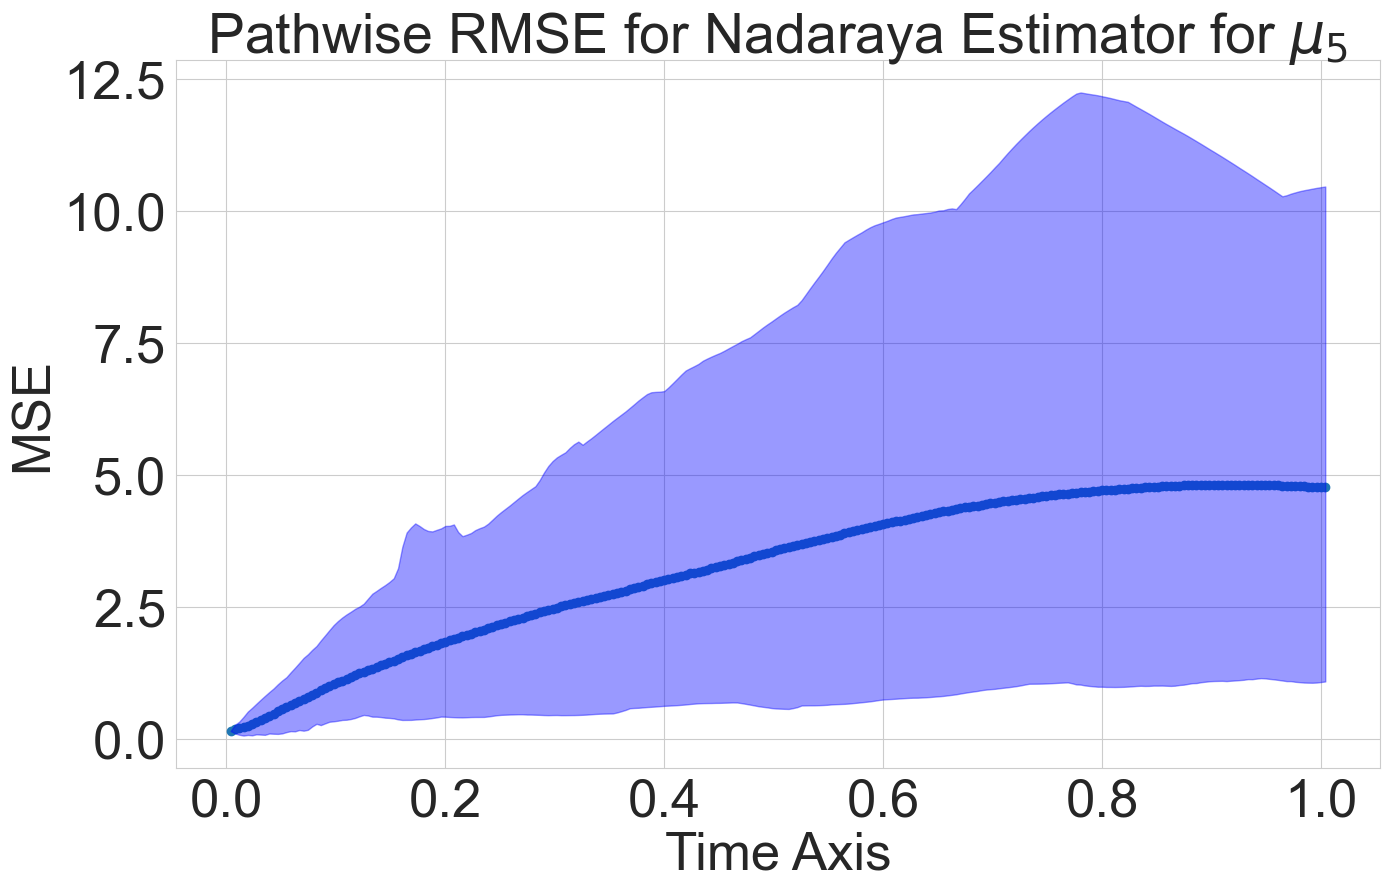

Final time cumulative MSE local-time error 4.766290334167042 at bw 0.0168214 for 0.75FConst



In [5]:
curr_rmse = np.inf
toSave = True
i = 0
for file in zip(*[true_files, local_files, bws]):
    bw = file[-1]
    all_true_states = np.load(file[0])
    all_local_states = np.load(file[1])
    if all_local_states.shape[0] != 2: continue
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)
        print(total_local_errors[-1], bw, curr_rmse)
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(rf"Pathwise RMSE for Nadaraya Estimator for $\mu_5$",fontsize=40)
            ax.set_ylabel("MSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir + f"DiffusionModelPresentationImages/IIDNadaraya/8DLnz/IIDNadaraya_8DLnz_DriftTrack_{round(bw, 6)}bw_{config.forcing_const}FConst_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} at bw {bw} for {config.forcing_const}FConst\n")

In [6]:
good_idx = 38
bad_idx = 35
good_true = np.load(true_files[good_idx])[0, :, :, :]
good_local = np.load(local_files[good_idx])[0, :,:, :]
bad_true = np.load(true_files[bad_idx])[0, :, :, :]
bad_local = np.load(local_files[bad_idx])[0, :, :,:]
print(bad_local.shape, bad_true.shape)
B, T, D = bad_local.shape

IndexError: list index out of range

In [ ]:
for dim in range(config.ndims):
    dim_idx = dim + 1
    time_ax = np.linspace(config.t0,config.deltaT*T,T)
    # Print different "true sample paths"
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for _ in range(B):
        axes[0].scatter(time_ax, good_true[_, :, dim]-good_local[_, :, dim], color="red", s=1)
        axes[1].scatter(time_ax, bad_true[_, :, dim]-bad_local[_, :, dim], color="blue", s=1)
    plt.suptitle(f"True vs Score-Based Path Difference for Dimension {dim_idx}\n")
    plt.xlabel("Time")
    plt.ylabel("Path")
    plt.show()
    plt.close()